<p><font size="6"><b> Raster - vector tools</b></font></p>


> *DS Python for GIS and Geoscience*  
> *October, 2020*
>
> *© 2020, Joris Van den Bossche and Stijn Van Hoey. Licensed under [CC BY 4.0 Creative Commons](http://creativecommons.org/licenses/by/4.0/)*

---

In the previous notebooks, we mostly worked with either vector data or raster data. 
But, often you will encounter both types of data and will have to combine them.
In this notebook, we show *some* examples of raster/vector interactions.

In [3]:
import pandas as pd
import numpy as np
import geopandas
import rasterio
from rasterio.plot import show

import matplotlib.pyplot as plt

In [4]:
countries = geopandas.read_file("zip://./data/ne_110m_admin_0_countries.zip")
cities = geopandas.read_file("zip://./data/ne_110m_populated_places.zip")

## Extracting values from rasters based on vector data

The **rasterstats** package provides methods to calculate summary statistics of geospatial raster datasets based on vector geometries (https://github.com/perrygeo/python-rasterstats)

To illustrate this, we are reading a raster file with elevation data of the full world (the file contains a single band for the elevation, save the file in the `data` subdirectory; [download link](https://www.eea.europa.eu/data-and-maps/data/world-digital-elevation-model-etopo5/zipped-dem-geotiff-raster-geographic-tag-image-file-format-raster-data/zipped-dem-geotiff-raster-geographic-tag-image-file-format-raster-data/at_download/file)):

In [5]:
dem_geotiff = "data/raw/dem_geotiff/DEM_geotiff/alwdgg.tif"

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': None, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["Clarke_1866",DATUM["Clarke_1866",SPHEROID["Clarke 1866",6378206.4,294.978698213898]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]'), 'transform': Affine(0.0833333358168602, 0.0, -179.99999491497874,
       0.0, -0.0833333358168602, 90.00000254437327)}


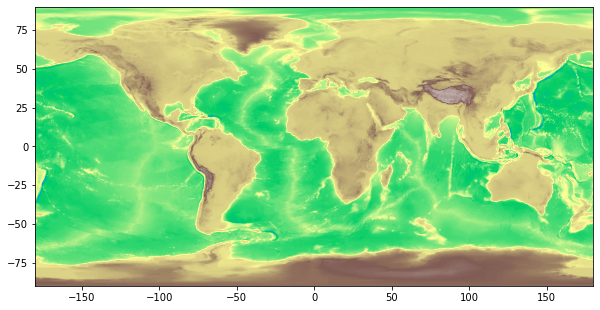

In [6]:
with rasterio.open(dem_geotiff) as src:
    print(src.meta)
    fig, ax = plt.subplots(figsize=(10, 6))
    show(src, ax=ax, cmap='terrain')

Given this raster of the elevation, we might want to know the elevation at a certain location or for each country.
For the countries example, we want to extract the pixel values that fall within a country polygon, and calculate a statistic for it, such as the mean or the maximum.

Such functionality to extract information from a raster for given vector data is provided by the rasterstats package.

In [7]:
import rasterstats

For extracting the pixel values for polygons, we use the `zonal_stats` function, passing it the GeoSeries, the path to the raster file, and the method to compute the statistics.

In [8]:
result = rasterstats.zonal_stats(countries.geometry, dem_geotiff,
                                 stats=['min', 'mean', 'max'])

/home/stijnvh/miniconda3/envs/DS-geospatial/lib/python3.8/site-packages/rasterstats/io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


The results can be assigned to new columns:

In [9]:
countries[['min', 'max', 'mean']] = pd.DataFrame(result)

In [10]:
countries.head()

,iso_a3,name,continent,pop_est,gdp_md_est,geometry,min,max,mean
0,AFG,Afghanistan,Asia,34124811.0,64080.0,"POLYGON ((61.21082 35.65007, 62.23065 35.27066...",244.0,5699.0,1865.941620
1,AGO,Angola,Africa,29310273.0,189000.0,"MULTIPOLYGON (((23.90415 -11.72228, 24.07991 -...",-1002.0,2103.0,1070.461868
2,ALB,Albania,Europe,3047987.0,33900.0,"POLYGON ((21.02004 40.84273, 20.99999 40.58000...",-250.0,2138.0,731.139738
3,ARE,United Arab Emirates,Asia,6072475.0,667200.0,"POLYGON ((51.57952 24.24550, 51.75744 24.29407...",-44.0,1524.0,115.114370
4,ARG,Argentina,South America,44293293.0,879400.0,"MULTIPOLYGON (((-66.95992 -54.89681, -67.56244...",-945.0,5181.0,655.130176


And then we can sort by the average elevation of the country:

In [11]:
countries.sort_values('mean', ascending=False).head()

,iso_a3,name,continent,pop_est,gdp_md_est,geometry,min,max,mean
157,TJK,Tajikistan,Asia,8468555.0,25810.0,"POLYGON ((74.980 37.420, 73.949 37.422, 73.260...",335.0,6096.0,3103.231105
85,KGZ,Kyrgyzstan,Asia,5789122.0,21010.0,"POLYGON ((80.260 42.350, 80.119 42.124, 78.544...",610.0,5791.0,2867.717142
24,BTN,Bhutan,Asia,758288.0,6432.0,"POLYGON ((91.697 27.772, 92.104 27.453, 92.033...",305.0,5486.0,2573.559846
119,NPL,Nepal,Asia,29384297.0,71520.0,"POLYGON ((81.111 30.183, 81.526 30.423, 82.328...",61.0,6705.0,2408.907816
6,ATA,Antarctica,Antarctica,4050.0,810.0,"MULTIPOLYGON (((-59.572 -80.040, -59.866 -80.5...",-1970.0,4115.0,2374.075028


For points, a similar function called `point_query` can be used (specifying the interpolation method):

In [12]:
cities["elevation"] = rasterstats.point_query(cities.geometry, 
                                              dem_geotiff, interpolate='bilinear')

/home/stijnvh/miniconda3/envs/DS-geospatial/lib/python3.8/site-packages/rasterstats/io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


In [13]:
cities.sort_values(by="elevation", ascending=False).head()

,name,geometry,elevation
122,La Paz,POINT (-68.15193 -16.49603),4378.784708
126,Thimphu,POINT (89.63901 27.47299),3554.551761
114,Sucre,POINT (-65.25952 -19.04097),3116.501683
88,Quito,POINT (-78.50200 -0.21304),2748.044039
211,Kabul,POINT (69.18131 34.51864),2588.508886


## Convert vector to raster

### Load DEM raster and river vector data

As example, we are using data from the Zwalm river area in Flanders. 

The digital elevation model (DEM) can be downloaded via the [governmental website](https://download.vlaanderen.be/Producten/Detail?id=936&title=Digitaal_Hoogtemodel_Vlaanderen_II_DSM_raster_5_m) ([download link](https://downloadagiv.blob.core.windows.net/dhm-vlaanderen-ii-dsm-raster-5m/DHMVIIDSMRAS5m_k30.zip), extracted in the `/data` directory for this example)/ 

In [14]:
dem_zwalm_file = "data/DHMVIIDSMRAS5m_k30/GeoTIFF/DHMVIIDSMRAS5m_k30.tif"

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 6400, 'height': 4000, 'count': 1, 'crs': CRS.from_epsg(31370), 'transform': Affine(5.0, 0.0, 98000.0,
       0.0, -5.0, 178000.0)}


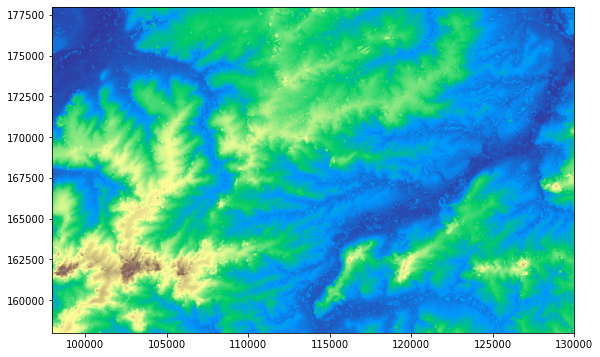

In [15]:
with rasterio.open(dem_zwalm_file) as src:
    print(src.meta)
    fig, ax = plt.subplots(figsize=(10, 6))
    #dem_zwalm = src.read(1)
    show(src, ax=ax, cmap='terrain')

Next, we download the shapes of the rivers in the area through a WFS (Web Feature Service):

In [16]:
import json
import requests

wfs_rivers = "https://geoservices.informatievlaanderen.be/overdrachtdiensten/VHAWaterlopen/wfs"
params = dict(service='WFS', version='1.1.0', request='GetFeature',
              typeName='VHAWaterlopen:Wlas', outputFormat='json',
              cql_filter="(VHAZONENR=460)OR(VHAZONENR=461)", srs="31370")

# Fetch data from WFS using requests
r = requests.get(wfs_rivers, params=params)

And convert this to a GeoDataFrame:

In [17]:
# Create GeoDataFrame from geojson
segments = geopandas.GeoDataFrame.from_features(json.loads(r.content), crs="epsg:31370")

In [18]:
segments.head()

,geometry,UIDN,OIDN,VHAS,VHAG,NAAM,REGCODE,REGCODE1,BEHEER,CATC,...,BEKNR,BEKNAAM,STRMGEB,KWALDOEL,LBLKWAL,GEO,LBLGEO,VHAZONENR,WTRLICHC,bbox
0,"LINESTRING (104155.250 174948.957, 104147.271 ...",356290,65768,6020608,5001,Zwalmbeek,OS266a,,V0104,1,...,6,Boven-Scheldebekken,Schelde,110,Produktie drinkwater,2,< 0.25 m,461,VL11_63,"[103860.8019, 174948.9569, 104155.2501, 175052..."
1,"LINESTRING (101574.265 175606.789, 101569.762 ...",358955,65539,6020496,5000,Zwalmbeek,OS266,,V0104,1,...,6,Boven-Scheldebekken,Schelde,131,Viswater en prod. drinkwater,2,< 0.25 m,461,VL11_63,"[100861.5388, 175566.6373, 101574.2653, 175682..."
2,"LINESTRING (100870.618 175566.637, 100868.874 ...",358962,65737,6020577,5000,Zwalmbeek,OS266,,V0104,1,...,6,Boven-Scheldebekken,Schelde,131,Viswater en prod. drinkwater,2,< 0.25 m,461,VL11_63,"[100688.0183, 175562.7066, 100870.6185, 175615..."
3,"LINESTRING (106457.412 174082.427, 106455.008 ...",358966,65777,6020617,5000,Zwalmbeek,OS266,,V0104,1,...,6,Boven-Scheldebekken,Schelde,131,Viswater en prod. drinkwater,2,< 0.25 m,461,VL11_63,"[105901.209, 174057.7072, 106457.412, 174494.3..."
4,"LINESTRING (105267.452 174665.979, 105262.210 ...",376442,65542,6020499,5000,Zwalmbeek,OS266,,V0104,1,...,6,Boven-Scheldebekken,Schelde,131,Viswater en prod. drinkwater,2,< 0.25 m,461,VL11_63,"[104750.3062, 174665.9791, 105267.4518, 174791..."


<AxesSubplot:>

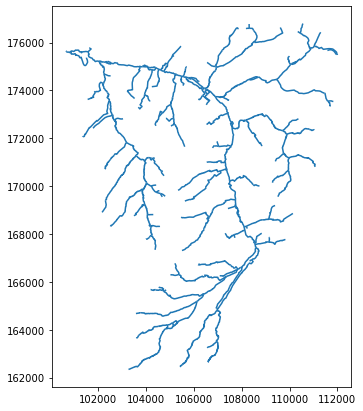

In [19]:
segments.plot(figsize=(8, 7))

### Clip raster with vector

_See also notebook `12-rasterio.ipynb`_

The catchment extent is much smaller than the DEM file, so clipping the data first will make the computation less heavy. 

Let's first download the catchment area of the Zwalm river from the Flemish government:

In [20]:
import json
import requests

wfs_bekkens = "https://geoservices.informatievlaanderen.be/overdrachtdiensten/Watersystemen/wfs"
params = dict(service='WFS', version='1.1.0', request='GetFeature',
              typeName='Watersystemen:WsDeelbek', outputFormat='json',
              cql_filter="DEELBEKNM='Zwalm'", srs="31370")

# Fetch data from WFS using requests
r = requests.get(wfs_bekkens, params=params)
catchment = geopandas.GeoDataFrame.from_features(json.loads(r.content), crs="epsg:31370")

In [21]:
catchment

,geometry,OIDN,UIDN,DEELBID,DEELBEKNM,bbox
0,"MULTIPOLYGON (((112222.397 176907.296, 112178....",165,264,06-05,Zwalm,"[100656.501, 162135.469, 112679.297, 177386.001]"


Save to a file for later reuse:

In [22]:
# save to file
catchment = catchment.to_crs('epsg:4326') # geojson is default 4326
del catchment["bbox"]
catchment.to_file("./data/zwalmbekken.geojson", driver="GeoJSON")

<AxesSubplot:>

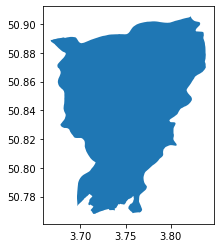

In [23]:
geopandas.read_file("./data/zwalmbekken.geojson").plot()

### 1. Using Rasterio

In [24]:
from rasterio.mask import mask

In [25]:
# cfr. The Rasterio workflow
with rasterio.open(dem_zwalm_file) as src: # 1

    # 2
    out_image, out_transform = mask(src, 
        catchment.to_crs('epsg:31370').geometry, crop=True)
    
    # 3
    zwalm_profile = src.profile
    zwalm_profile.update({"height": out_image.shape[1],
                          "width": out_image.shape[2],
                          "transform": out_transform})  
    # 4                              
    with rasterio.open("./dem_masked.tiff", "w", **zwalm_profile) as dest: 
        dest.write(out_image)

Check the output of the clipping:

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 2405, 'height': 3051, 'count': 1, 'crs': CRS.from_epsg(31370), 'transform': Affine(5.0, 0.0, 100655.0,
       0.0, -5.0, 177390.0)}


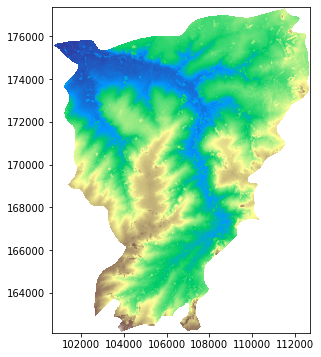

In [190]:
with rasterio.open("./dem_masked.tiff") as src:
    print(src.meta)
    dem_meta = src.meta
    transform =src.transform    
    fig, ax = plt.subplots(figsize=(10, 6))
    dem_zwalm = src.read(1)
    show(src, ax=ax, cmap='terrain')

### 2. Using GDAL CLI

If we have the raster and vector files on disk, [`gdal CLI`](https://gdal.org/programs/index.html) will be very fast to work with (note that GDAL automatically handles the CRS difference of the raster and vector). 

In [ ]:
!gdalwarp -cutline ./data/zwalmbekken.geojson -crop_to_cutline data/DHMVIIDSMRAS5m_k30/GeoTIFF/DHMVIIDSMRAS5m_k30.tif ./dem_masked_gdal.tiff

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 2403, 'height': 3049, 'count': 1, 'crs': CRS.from_epsg(31370), 'transform': Affine(5.0, 0.0, 100660.0,
       0.0, -5.0, 177385.0)}


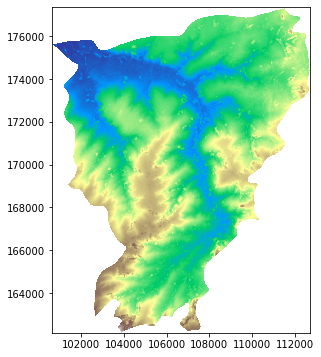

In [206]:
with rasterio.open("./dem_masked_gdal.tiff") as src:
    print(src.meta)
    fig, ax = plt.subplots(figsize=(10, 6))
    show(src, ax=ax, cmap='terrain')

### Convert vector to raster

To create a raster with the vector "burned in", we can use the `rasterio.features.rasterize` function. This expects a list of (shape, value) tuples, and an output image shape and transform. Here, we will create a new raster image with the same shape and extent as the DEM above. And we first take a buffer of the river lines:

In [30]:
segments_buffered = segments.geometry.buffer(100)
img = rasterio.features.rasterize(
    zip(segments_buffered, [1]*len(segments_buffered)), 
    out_shape=(3051, 2405), 
    transform=transform)

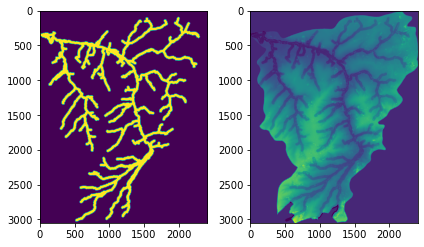

In [205]:
fig, (ax0, ax1) = plt.subplots(1, 2)
ax0.imshow(img*50)
ll = ax1.imshow(dem_zwalm - img*20) # just as an example
plt.tight_layout()

-----------

### A bit more about WFS

> The Web Feature Service (WFS) represents a change in the way geographic information is created, modified and exchanged on the Internet. Rather than sharing geographic information at the file level using File Transfer Protocol (FTP), for example, the WFS offers direct fine-grained...

(https://www.ogc.org/standards/wfs)

In brief, the WFS is the specification to __access and download vector datasets__.

To access WFS data, you need the following information:
- URL of the service, e.g. `https://geoservices.informatievlaanderen.be/overdrachtdiensten/VHAWaterlopen/wfs`. Looking for these URLS, check [WFS page of Michel Stuyts](https://wfs.michelstuyts.be/?lang=en)
- The available projections and layers, also check [WFS page of Michel Stuyts](https://wfs.michelstuyts.be/?lang=en) or start looking into the `GetCapabilities`, e.g. [vha waterlopen](https://geoservices.informatievlaanderen.be/overdrachtdiensten/VHAWaterlopen/wfs?REQUEST=GetCapabilities&SERVICE=WFS)

Instead of downloading the entire data set, filtering the request itself (only downloading what you need) is a good idea, using the `cql_filter` filter. Finding out these is sometimes a bit of hazzle... E.g. quickly [preview the data in QGIS](https://docs.qgis.org/3.10/en/docs/training_manual/online_resources/wfs.html?highlight=wfs).

You can also use the [`OWSLib` library](https://geopython.github.io/OWSLib/#wfs). But as WFS is a webservice, the `requests` package will be sufficient for simple queries. 

As an example - municipalities in Belgium, see https://wfs.michelstuyts.be/service.php?id=140&lang=en, _WFS Voorlopig referentiebestand gemeentegrenzen 2019_

- URL of the service: https://geoservices.informatievlaanderen.be/overdrachtdiensten/VRBG2019/wfs
- Available projections:  EPSG:4258, EPSG:3812,...
- Available layers: VRBG2019:Refgem:,  VRBG2019:Refarr:,...
- Column `Naam` contains the municipatility, e.g. `Gent`

<AxesSubplot:>

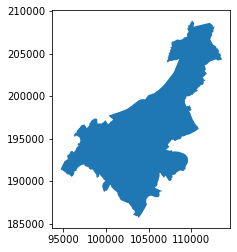

In [203]:
wfs_municipality = "https://geoservices.informatievlaanderen.be/overdrachtdiensten/VRBG2019/wfs"
params = dict(service='WFS', version='1.1.0', request='GetFeature',
              typeName='VRBG2019:Refgem', outputFormat='json',
              cql_filter="NAAM='Gent'", srs="31370")

# Fetch data from WFS using requests
r = requests.get(wfs_municipality, params=params)
gent = geopandas.GeoDataFrame.from_features(json.loads(r.content), crs="epsg:31370")
gent.plot()

-----------
-----------